In [1]:
import pandas as pd

data = pd.read_csv("labeled_data.csv", encoding = "ISO-8859-1")
data.head(2)

,Unnamed: 0,id,created_at,date,time,timezone,user_id,username,name,tweet,language,link,retweet,sentiment
0,1439,1.520000e+18,2022-05-05 07:38:56 Turkey Standard Time,5/5/2022,7:38:56,300,1.230000e+18,mayank_twts,Mayank Verma,EdTech Startup ÃÂ¢ÃÂÃÂ The industry that...,en,https://twitter.com/mayank_twts/status/1522073...,False,1
1,726,1.520000e+18,2022-05-03 22:50:03 Turkey Standard Time,5/3/2022,22:50:03,300,9.260000e+17,huntingtonngc,Huntington Learning,There are a lot of unknowns about this school ...,en,https://twitter.com/HuntingtonNGC/status/15215...,False,0


In [2]:
data.loc[data["sentiment"] != 2, "sentiment"] = 1
data.loc[data["sentiment"] == 2, "sentiment"] = 0
data["sentiment"].unique()

array([1, 0], dtype=int64)

In [3]:
x = data["tweet"]
y = data["sentiment"]

print(x.shape)
print(y.shape)

(2223,)
(2223,)


In [4]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

sentence_all = list()
lines = x.to_list()

for line in lines:
    tokens = word_tokenize(line)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('','',string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words("english"))
    words = [w for w in words if not w in stop_words]
    sentence_all.append(words)

print(sentence_all[0])
print(sentence_all[1])
print(sentence_all[2])

['edtech', 'startup', 'industry', 'gained', 'attention', 'uncertain', 'times', 'education', 'industry', 'students', 'teachers', 'feel', 'burned', 'pandemic', 'learning', 'companies', 'market', 'online', 'learning', 'tools', 'schools', 'enjoying', 'coronavirus', 'windfall']
['lot', 'unknowns', 'school', 'year', 'let', 'child', 'stands', 'one', 'call', 'learn', 'schedule', 'academic', 'evaluation', 'huntingtonhelps', 'remotelearning', 'hybridlearning', 'distancelearning', 'tutoring', 'https', 'tcokuapcpjebh']
['cut', 'statistical', 'fallacies', 'counting', 'dead', 'serious', 'business', 'underreporting', 'deaths', 'multiple', 'eventually', 'show', 'crude', 'death', 'rates', 'years']


In [5]:
import gensim

embedding_dim = 50
model = gensim.models.Word2Vec(sentences=sentence_all,vector_size=embedding_dim,window=5,workers=4,min_count=1)
words = len(model.wv)
print("Vocabulary size: %d"%(words))
model.wv.save_word2vec_format("nn1_embed.txt",binary=False)

Vocabulary size: 9053


In [6]:
import os
import numpy as np

embedding_index = {}
f = open(os.path.join('',"nn1_embed.txt"))

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embedding_index[word] = coefs

f.close()

In [7]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentence_all)

sentences = tokenizer.texts_to_sequences(sentence_all)

word_index = tokenizer.word_index
print("Unique tokens:%d"%len(word_index))
print(sentence_all[0])
print(sentences[0])

Unique tokens:9053
['edtech', 'startup', 'industry', 'gained', 'attention', 'uncertain', 'times', 'education', 'industry', 'students', 'teachers', 'feel', 'burned', 'pandemic', 'learning', 'companies', 'market', 'online', 'learning', 'tools', 'schools', 'enjoying', 'coronavirus', 'windfall']
[49, 3777, 248, 1737, 1389, 2401, 317, 4, 248, 8, 21, 1390, 3778, 11, 2, 1142, 508, 5, 2, 561, 19, 2402, 7, 3779]


In [8]:
from keras.preprocessing.sequence import pad_sequences

maxlen = max([len(x) for x in sentences])
print("Maxlen:",maxlen)

sentences = pad_sequences(sentences, padding='post',maxlen=maxlen)
print("Shape : ", sentences.shape)

Maxlen: 37
Shape :  (2223, 37)


In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

xTrain, xTest, yTrain, yTest = train_test_split(sentences, y, test_size=0.25)
print(xTrain.shape,xTest.shape)
print(yTrain.shape,yTest.shape)

yTrain = to_categorical(yTrain)
yTest = to_categorical(yTest)

(1667, 37) (556, 37)
(1667,) (556,)


In [10]:
from keras.models import Sequential
from keras.layers import *
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.regularizers import l1,l2 

d_rate = 0.7
r_factor = 0.01

model = Sequential()

model.add(Embedding((len(word_index)+1), embedding_dim,input_length=maxlen,trainable=False))
model.add(LSTM(32))
model.add(Flatten())
model.add(Dense(8,activation="tanh",kernel_regularizer=l2(r_factor), bias_regularizer=l2(r_factor)))
model.add(Dense(8,activation="tanh",kernel_regularizer=l2(r_factor), bias_regularizer=l2(r_factor)))
model.add(Dropout(d_rate))
model.add(Dense(2,activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 37, 50)            452700    
                                                                 
 lstm (LSTM)                 (None, 32)                10624     
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 2)                 1

In [11]:
model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])
model_history = model.fit(xTrain,yTrain,epochs=50,validation_data=(xTest,yTest))

Epoch 1/50
53/53 [==============================] - 4s 36ms/step - loss: 0.8716 - accuracy: 0.5255 - val_loss: 0.8382 - val_accuracy: 0.5558
Epoch 2/50
53/53 [==============================] - 2s 32ms/step - loss: 0.8176 - accuracy: 0.5501 - val_loss: 0.7937 - val_accuracy: 0.5558
Epoch 3/50
53/53 [==============================] - 2s 37ms/step - loss: 0.7799 - accuracy: 0.5387 - val_loss: 0.7614 - val_accuracy: 0.5558
Epoch 4/50
53/53 [==============================] - 4s 68ms/step - loss: 0.7517 - accuracy: 0.5387 - val_loss: 0.7388 - val_accuracy: 0.5558
Epoch 5/50
53/53 [==============================] - 2s 36ms/step - loss: 0.7328 - accuracy: 0.5387 - val_loss: 0.7229 - val_accuracy: 0.5558
Epoch 6/50
53/53 [==============================] - 2s 45ms/step - loss: 0.7193 - accuracy: 0.5387 - val_loss: 0.7117 - val_accuracy: 0.5558
Epoch 7/50
53/53 [==============================] - 3s 63ms/step - loss: 0.7097 - accuracy: 0.5387 - val_loss: 0.7043 - val_accuracy: 0.5558
Epoch 8/50
53

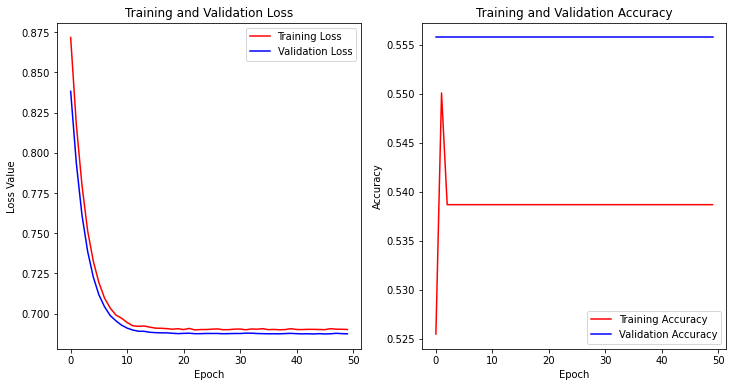

In [12]:
import matplotlib.pyplot as plt

trainLoss = model_history.history["loss"]
valLoss = model_history.history["val_loss"]
trainAccuracy = model_history.history["accuracy"]
valAccuracy = model_history.history["val_accuracy"]

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(trainLoss, "r",label="Training Loss")
plt.plot(valLoss, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()

plt.subplot(1,2,2)
plt.plot(trainAccuracy, "r",label="Training Accuracy")
plt.plot(valAccuracy, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

Text(0.5, 1.0, 'ROC Curve')

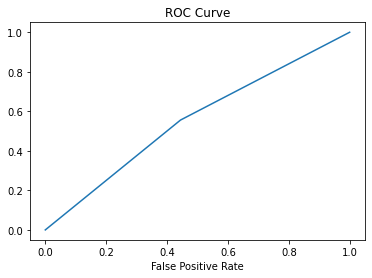

In [13]:
from sklearn.metrics import roc_curve

yPred = model.predict(xTest)

fpr, tpr, thresholds = roc_curve(yTest.ravel(),yPred.ravel())
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve")